In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('itamplify_train.csv')
columns_to_drop = ['track_name', 'track_id', 'artists', 'album_name', 'X']
data = data.drop(columns_to_drop, axis=1)
print(data.dtypes)
print(data.head())

popularity            int64
duration_ms           int64
explicit              int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object
   popularity  duration_ms  explicit  danceability  energy  key  loudness  \
0          64       168000         0         0.443   0.778    0    -7.564   
1          44       318360         0         0.580   0.800    6    -7.528   
2          42       171989         0         0.805   0.746    1    -5.211   
3          46       205440         0         0.582   0.660    7    -4.988   
4          44       220800         0         0.776   0.314    2    -9.513   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \


In [3]:
print(f"time_signature: {data['time_signature'].unique()}")
print(f"key: {data['key'].unique()}")

time_signature: [5 4 3 1 0]
key: [ 0  6  1  7  2  8  9 10  4 11  5  3]


In [4]:
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader

# Identify categorical and numerical columns
categorical_columns = ['key', 'time_signature']
numerical_columns = ['popularity', 'duration_ms', 'loudness', 'tempo', 
                     'danceability', 'energy', 'speechiness', 'acousticness', 
                     'instrumentalness','liveness', 'valence']

# Create a transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Prepare target mapping for genres
genres = data['track_genre'].unique()
genre_to_idx = {genre: idx for idx, genre in enumerate(genres)}
data['track_genre'] = data['track_genre'].map(genre_to_idx)

# Split the data
features = data.drop('track_genre', axis=1)
target = data['track_genre']

# Apply preprocessing
X = preprocessor.fit_transform(features)
y = target.values

# Convert arrays to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create data loaders for batch processing
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [5]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MusicGenreClassifier(nn.Module):
    def __init__(self):
        super(MusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)  # Adjust the input size based on the number of features after preprocessing
        self.fc5 = nn.Linear(64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, len(genres))  # Output size is the number of genres

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc5(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [19]:
model = MusicGenreClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 300

Epoch 1: Train Loss: 2.6538, Train Acc: 14.61%, Val Loss: 2.5695, Val Acc: 15.90%
Epoch 11: Train Loss: 1.6815, Train Acc: 44.63%, Val Loss: 1.6242, Val Acc: 46.07%
Epoch 21: Train Loss: 1.5894, Train Acc: 48.05%, Val Loss: 1.5452, Val Acc: 48.97%
Epoch 31: Train Loss: 1.5225, Train Acc: 49.70%, Val Loss: 1.4943, Val Acc: 49.27%
Epoch 41: Train Loss: 1.4713, Train Acc: 51.75%, Val Loss: 1.4618, Val Acc: 51.15%
Epoch 51: Train Loss: 1.4247, Train Acc: 53.78%, Val Loss: 1.4364, Val Acc: 51.69%
Epoch 61: Train Loss: 1.3948, Train Acc: 54.10%, Val Loss: 1.4209, Val Acc: 52.36%
Epoch 71: Train Loss: 1.3733, Train Acc: 54.75%, Val Loss: 1.4001, Val Acc: 53.39%
Epoch 81: Train Loss: 1.3366, Train Acc: 55.88%, Val Loss: 1.3978, Val Acc: 53.75%
Epoch 91: Train Loss: 1.3064, Train Acc: 57.27%, Val Loss: 1.3826, Val Acc: 54.59%
Epoch 101: Train Loss: 1.2889, Train Acc: 57.35%, Val Loss: 1.3751, Val Acc: 54.47%
Epoch 111: Train Loss: 1.2746, Train Acc: 57.97%, Val Loss: 1.3679, Val Acc: 54.47%
Epo

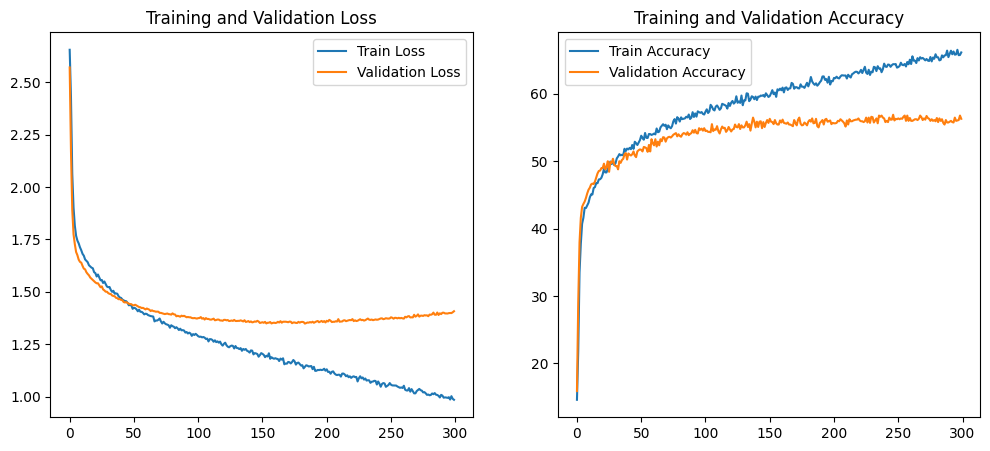

In [20]:
import matplotlib.pyplot as plt

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Send data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    correct = total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Send data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    if(epoch % 10 == 0):
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [21]:
# Create dictionaries to hold counts for each class
correct_class = {genre: 0 for genre in genres}
total_class = {genre: 0 for genre in genres}

# Validation phase with class-wise accuracy calculation
model.eval()
val_running_loss = 0.0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_class[genres[label.item()]] += 1
            total_class[genres[label.item()]] += 1

val_loss = val_running_loss / len(val_loader)

# Print class-wise accuracy
class_accuracies = {genre: 100 * correct_class[genre] / total_class[genre] for genre in genres if total_class[genre] > 0}
for genre, accuracy in class_accuracies.items():
    print(f'Acc. {genre}: {accuracy:.2f}%')


Acc. afrobeat: 36.76%
Acc. alternative: 41.67%
Acc. blues: 24.17%
Acc. classical: 64.00%
Acc. country: 29.31%
Acc. disco: 56.83%
Acc. folk: 43.14%
Acc. funk: 65.87%
Acc. heavy-metal: 73.81%
Acc. hip-hop: 70.43%
Acc. jazz: 18.52%
Acc. psych-rock: 51.74%
Acc. reggaeton: 54.05%
Acc. samba: 80.00%
Acc. techno: 75.86%


---

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load your dataset
data = pd.read_csv('itamplify_train.csv')

# Existing feature dropping
columns_to_drop = ['track_name', 'track_id', 'artists', 'album_name', 'X']
data = data.drop(columns_to_drop, axis=1)

# Feature engineering
data['dance_energy_interaction'] = data['danceability'] * data['energy']
data['loudness_squared'] = data['loudness'] ** 2
data['tempo_binned'] = pd.cut(data['tempo'], bins=[0, 60, 120, 180, 240], labels=['slow', 'moderate', 'fast', 'very_fast'])
data['rhythmic_stat'] = (data['danceability'] + data['tempo'] + data['time_signature']) / 3
data['key_sin'] = np.sin(2 * np.pi * data['key'] / 12)
data['key_cos'] = np.cos(2 * np.pi * data['key'] / 12)
data['speechiness_acousticness_ratio'] = data['speechiness'] / (data['acousticness'] + 0.001)  # To avoid division by zero
data['avg_loudness_energy'] = (data['loudness'] + data['energy']) / 2

# Mapping genres to indices for classification
genres = data['track_genre'].unique()
genre_to_idx = {genre: idx for idx, genre in enumerate(genres)}
data['track_genre'] = data['track_genre'].map(genre_to_idx)

# Prepare data for modeling
features = data.drop('track_genre', axis=1)
labels = data['track_genre']

# Identify categorical and numerical columns for different preprocessing
categorical_features = ['tempo_binned']
numerical_features = list(features.columns.difference(categorical_features))

# Column Transformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)

# Apply the preprocessing
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values)
X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Data preparation complete and ready for training with RobustScaler.")


Data preparation complete and ready for training with RobustScaler.


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedMusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedMusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Adjust the input size to match the new feature count
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)  # Number of genres remains the same

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)  # Regularization with dropout
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5, training=self.training)  # Regularization with dropout
        x = self.fc3(x)
        return x


In [26]:
# Example of initializing the model with updated feature size
num_features = X_train.shape[1]  # Make sure this is calculated after all feature engineering steps
num_classes = len(genres)
model = EnhancedMusicGenreClassifier(input_size=num_features, num_classes=num_classes).to(device)
num_epochs = 500


optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()



Epoch 1: Train Loss: 1.1636, Train Acc: 60.77%, Val Loss: 1.2777, Val Acc: 58.10%
Epoch 11: Train Loss: 1.1601, Train Acc: 60.92%, Val Loss: 1.2751, Val Acc: 58.59%
Epoch 21: Train Loss: 1.1565, Train Acc: 60.92%, Val Loss: 1.2723, Val Acc: 58.28%
Epoch 31: Train Loss: 1.1451, Train Acc: 60.95%, Val Loss: 1.2729, Val Acc: 57.98%
Epoch 41: Train Loss: 1.1449, Train Acc: 61.66%, Val Loss: 1.2700, Val Acc: 57.86%
Epoch 51: Train Loss: 1.1350, Train Acc: 61.87%, Val Loss: 1.2683, Val Acc: 58.22%
Epoch 61: Train Loss: 1.1303, Train Acc: 62.39%, Val Loss: 1.2695, Val Acc: 58.10%
Epoch 71: Train Loss: 1.1172, Train Acc: 62.87%, Val Loss: 1.2684, Val Acc: 58.52%
Epoch 81: Train Loss: 1.1138, Train Acc: 62.58%, Val Loss: 1.2699, Val Acc: 58.65%
Epoch 91: Train Loss: 1.1028, Train Acc: 62.48%, Val Loss: 1.2715, Val Acc: 58.40%
Epoch 101: Train Loss: 1.0952, Train Acc: 62.72%, Val Loss: 1.2696, Val Acc: 58.89%
Epoch 111: Train Loss: 1.1006, Train Acc: 62.48%, Val Loss: 1.2698, Val Acc: 58.83%
Epo

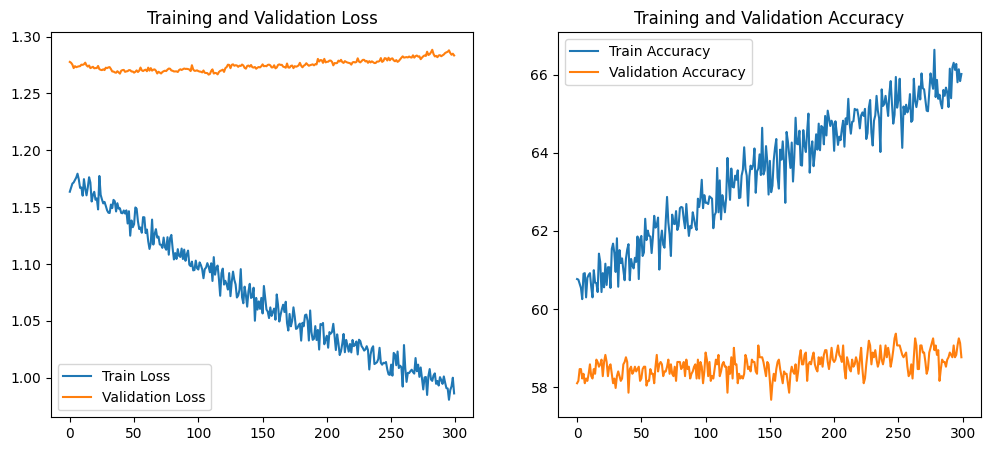

In [28]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Send data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    correct = total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Send data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    if(epoch % 10 == 0):
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
